In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
from newspaper import Article, fulltext
import regex as re
import html
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import string
from nltk.stem import LancasterStemmer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.manifold import MDS
from matplotlib import pyplot as plt
import sklearn.datasets as dt
import seaborn as sns         
import numpy as np
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [2]:
# Data cleaning to remove escape characters
def escape_replacer(s):
    s = s.replace('\n', ' ')
    s = s.replace('\t', '')
    s = s.replace('\'', '')
    return s

In [3]:
# Function to remove punctuation
def removepunc(item):
    for p in string.punctuation:
        item = item.lstrip().replace(p,'')
    return item

In [4]:
# Tokenizing and removing stop words
def word_ops(s):
    stop_words = set(stopwords.words('english'))
    tokenizer = RegexpTokenizer(r'\w+')
    word_tokens = word_tokenize(s)
    filtered_comments = [w.lower() for w in word_tokens if w.lower() not in stop_words]
    return filtered_comments

In [5]:
# Article list from different sources
df = pd.read_csv('CleanedArticles.csv')
df

,url,Twitter Link,Source
0,https://www.foxnews.com/media/unvaccinated-den...,https://twitter.com/FoxNews/status/14436216695...,Fox News
1,https://www.foxnews.com/health/us-covid-19-cas...,https://twitter.com/FoxNews/status/14436027885...,Fox News
2,https://www.foxnews.com/sports/ted-cruz-nba-pl...,https://twitter.com/FoxNews/status/14435348410...,Fox News
3,https://www.foxnews.com/media/liberal-journali...,https://twitter.com/FoxNews/status/14434782190...,Fox News
4,https://www.foxnews.com/health/covid-vaccinati...,https://twitter.com/FoxNews/status/14432869571...,Fox News
...,...,...,...
61,https://www.huffpost.com/entry/can-i-get-covid...,https://twitter.com/HuffPost/status/1441435677...,Huffpost
62,https://www.huffpost.com/entry/anti-covid-vacc...,https://twitter.com/HuffPost/status/1441392093...,Huffpost
63,https://www.huffpost.com/entry/moderna-ceo-cov...,https://twitter.com/HuffPost/status/1441352055...,Huffpost
64,https://www.huffpost.com/entry/cdc-director-bo...,https://twitter.com/HuffPost/status/1441290739...,Huffpost


In [6]:
# Getting individual articles
def article_extract(s):
    article = Article(s)
    article.download()
    article.parse()
    return article.text

df['Articles'] = df['url'].apply(article_extract)

In [7]:
# Extracting keywords
def keyword_extract(x):
    article = Article(x)
    article.download()
    article.parse()
    article.nlp()
    return article.keywords

df['Keywords'] = df['url'].apply(keyword_extract)

In [8]:
# Cleaning up all articles using earlier defined functions
# Removing escape characters, removing punctuation, tokenizing and removing stop words
df['Cleaned_Articles'] = df['Articles'].apply(escape_replacer)
df['Cleaned_Articles'] = df['Cleaned_Articles'].apply(removepunc)
df['Article_Tokens'] = df['Cleaned_Articles'].apply(word_ops)

In [9]:
fancy_list = ['’','–']
# removing apostrophes and hyphens

def fancy_remove(x):
    y = list(x for x in x if x not in fancy_list)
    return y

df['Article_Tokens'] = df['Article_Tokens'].apply(fancy_remove)
df['Keywords'] = df['Keywords'].apply(fancy_remove)

In [10]:
LS = LancasterStemmer()
PS = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

def stemmer(s):
    stemmed = []
    for i in s:
        i = LS.stem(i)
        stemmed.append(i)
    return stemmed

df['Stemmed_Tokens'] = df['Article_Tokens'].apply(stemmer)

In [11]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sd = SentimentIntensityAnalyzer()

In [12]:
df['Cleaned_Articles_with_Punctuation'] = df['Articles'].apply(escape_replacer)

In [13]:
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    
    final_sentences = []
    list_strings = ['vacc', 'covid', 'corona', 'vax', 'johnson', 'pfizer', 'moderna', 'virus', 'mandate']
    for i in sentences:
        if any(ele in i.lower() for ele in list_strings):
            final_sentences.append(i)
    
    return final_sentences

In [14]:
def sentiment_score(text):    
    article_sentences = split_into_sentences(text)
    scores = []
    for i in article_sentences:
        scores.append(sd.polarity_scores(i))
    
    negative_score = round(sum(d['neg'] for d in scores) / len(scores), 4)
    neutral_score = round(sum(d['neu'] for d in scores) / len(scores), 4)
    positive_score = round(sum(d['pos'] for d in scores) / len(scores), 4)
    compound_score = round(sum(d['compound'] for d in scores) / len(scores), 4)
    if compound_score > 0.05:
        average_sentiment = 'Positive'
    elif compound_score < -0.05:
        average_sentiment = 'Negative'
    else:
        average_sentiment = 'Neutral'

    final_score = [negative_score, neutral_score, positive_score, compound_score, average_sentiment]
    
    return final_score

In [15]:
negative_scores = []
neutral_scores = []
positive_scores = []
compound_scores = []
average_sentiments = []

for i in range(0, len(df)):
    negative_scores.append(sentiment_score(df['Cleaned_Articles_with_Punctuation'].iloc[i])[0])
    neutral_scores.append(sentiment_score(df['Cleaned_Articles_with_Punctuation'].iloc[i])[1])
    positive_scores.append(sentiment_score(df['Cleaned_Articles_with_Punctuation'].iloc[i])[2])
    compound_scores.append(sentiment_score(df['Cleaned_Articles_with_Punctuation'].iloc[i])[3])
    average_sentiments.append(sentiment_score(df['Cleaned_Articles_with_Punctuation'].iloc[i])[4])
    
df.insert(8, 'Negative_Score', negative_scores)
df.insert(9, 'Neutral_Score', neutral_scores)
df.insert(10, 'Positive_Score', positive_scores)
df.insert(11, 'Compound_Score', compound_scores)
df.insert(12, 'Average_Sentiment', average_sentiments)

df.insert(13, 'Unaveraged_Score', df['Cleaned_Articles'].apply(lambda x: sd.polarity_scores(x)))

In [216]:
df_source_sentiments = df.groupby('Source').agg({'Positive_Score': 'mean', 'Neutral_Score': 'mean', 'Negative_Score': 'mean', 'Compound_Score': 'mean'})
df_source_sentiments_temp = df.groupby(['Source', 'Average_Sentiment']).size().unstack()
df_source_sentiments = df_source_sentiments.merge(df_source_sentiments_temp, left_index = True, right_index = True).rename(columns={'Negative': 'Negative_Count', 'Neutral': 'Neutral_Count', 'Positive': 'Positive_Count'})
print('Sentiment Scores:')
df_source_sentiments[['Compound_Score']]

Sentiment Scores:


,Compound_Score
Source,
Breitbart,-0.114630
CNN,0.178793
Fox News,-0.001559
Huffpost,0.072333
Reuters,0.054156


In [17]:
df.groupby('Source').count()

,url,Twitter Link,Articles,Keywords,Cleaned_Articles,Article_Tokens,Stemmed_Tokens,Negative_Score,Neutral_Score,Positive_Score,Compound_Score,Average_Sentiment,Unaveraged_Score,Cleaned_Articles_with_Punctuation
Source,,,,,,,,,,,,,,
Breitbart,10,10,10,10,10,10,10,10,10,10,10,10,10,10
CNN,15,15,15,15,15,15,15,15,15,15,15,15,15,15
Fox News,17,17,17,17,17,17,17,17,17,17,17,17,17,17
Huffpost,15,15,15,15,15,15,15,15,15,15,15,15,15,15
Reuters,9,9,9,9,9,9,9,9,9,9,9,9,9,9


In [18]:
df_fox = df[df['Source'] == 'Fox News']
df_cnn = df[df['Source'] == 'CNN']
df_breitbart = df[df['Source'] == 'Breitbart']
df_huffpost = df[df['Source'] == 'Huffpost']
df_reuters = df[df['Source'] == 'Reuters']

In [19]:
source_list = ['fox', 'cnn', 'breitbart', 'huffpost', 'reuters']

In [20]:
df_cnn.reset_index(drop = True, inplace=True)
df_breitbart.reset_index(drop = True, inplace=True)
df_huffpost.reset_index(drop = True, inplace=True)
df_reuters.reset_index(drop = True, inplace=True)

df_list = [df_fox, df_cnn, df_breitbart, df_huffpost, df_reuters]
# df_list

In [21]:
def word_counts(df):
    word_counts = {}
    art = np.concatenate(df)
    words = []
    words += (j for j in art)
    word_counts[source_list[i]] = Counter(words)

    return word_counts

article_of_dicts = []
stem_of_dicts = []

for i in range(len(source_list)):
    c = Counter(np.concatenate(df_list[i]['Article_Tokens']))
    x = Counter(np.concatenate(df_list[i]['Stemmed_Tokens']))
    article_of_dicts.append({k:v for k,v in c.items() if v >= 10})
    stem_of_dicts.append({k:v for k,v in x.items() if v >= 10})

In [22]:
df_fox_words = pd.read_csv('fox_lift_words.csv',names=['Word']).dropna()

df_cnn_words = pd.read_csv('cnn_lift_words.csv', header=None, names = ['Word', 'Count']).dropna()

df_breitbart_words = pd.read_csv('breitbart_lift_words.csv', header=None, names = ['Word', 'Count']).dropna()

df_huffpost_words = pd.read_csv('huffpost_lift_words.csv', header=None, names = ['Word', 'Count']).dropna()

df_reuters_words = pd.read_csv('reuters_lift_words.csv', header=None, names = ['Word', 'Count']).dropna()

fox_words = list(df_fox_words['Word'])
cnn_words = list(df_cnn_words['Word'])
breitbart_words = list(df_breitbart_words['Word'])
huffpost_words = list(df_huffpost_words['Word'])
reuters_words = list(df_reuters_words['Word'])

all_words = [fox_words, cnn_words, breitbart_words, huffpost_words, reuters_words]

In [23]:
hits = []
for i in all_words:
    df_word_mentions = pd.DataFrame(columns = i)

    def word_mentioned(s):
        if w in s:
            return 1
        else:
            return 0

    for w in i: 
        df_word_mentions[w] = df['Stemmed_Tokens'].apply(word_mentioned)
    hits.append(df_word_mentions)

# hits =  'fox', 'cnn', 'breitbart', 'huffpost', 'reuters'
# hits[1]

In [24]:
lifts = []
for k,v in enumerate(hits):
    df_word_lifts = pd.DataFrame(columns = all_words[k], index = all_words[k])
    df_word_dissimilarity = df_word_lifts.copy()

    # Calculate Brand Lifts
    for i in range(0, len(df_word_lifts)-1):
        for j in range(i+1, len(df_word_lifts)):
            num_N = len(v)
            num_AB = sum(v[all_words[k][i]] & v[all_words[k][j]])
            denom_A = sum(v[all_words[k][i]])
            denom_B = sum(v[all_words[k][j]])
            lift_AB = (num_N * num_AB) / (denom_A * denom_B)
            df_word_lifts.iloc[i][j] = lift_AB
    lifts.append(df_word_lifts)

In [25]:
print('Lift Values for Fox')
lifts[0]

Lift Values for Fox


,heal,covid19,pregn,work,shot,boost,report,risk,cdc,stud,...,dat,dos,coronavir,immun,infect,staff,diseas,vir,pandem,complaint
heal,NaN,1.146218,1.885714,1.042105,1.399078,1.414286,0.862041,1.65,1.296429,0.707143,...,1.290226,1.147826,1.131429,1.346939,1.389474,0.942857,1.430542,1.290226,1.557764,1.885714
covid19,NaN,NaN,1.294118,1.089783,1.127135,1.164706,0.887395,1.132353,1.213235,1.132353,...,1.157895,1.069054,0.905882,1.232493,1.226006,0.889706,1.070994,0.885449,1.12532,0.647059
pregn,NaN,NaN,NaN,1.042105,1.703226,1.98,1.131429,2.75,4.125,0.0,...,2.084211,2.295652,1.32,1.257143,3.473684,0.825,2.275862,0.694737,1.721739,0.0
work,NaN,NaN,NaN,NaN,0.952462,1.215789,0.992481,1.230263,1.302632,1.085526,...,0.914127,0.981693,0.926316,0.992481,1.00554,1.194079,1.018149,0.914127,1.057208,0.868421
shot,NaN,NaN,NaN,NaN,NaN,2.022581,0.973272,1.508065,1.862903,0.798387,...,1.456706,1.758766,0.993548,1.317972,1.568761,0.665323,1.468298,1.344652,1.388499,2.129032
boost,NaN,NaN,NaN,NaN,NaN,NaN,0.848571,1.925,2.475,0.4125,...,1.563158,2.295652,0.88,1.885714,1.736842,0.4125,1.706897,1.215789,1.434783,0.0
report,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.864286,0.825,1.65,...,1.091729,1.065839,1.382857,0.718367,0.893233,0.942857,0.975369,1.091729,0.737888,0.942857
risk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.890625,0.6875,...,1.736842,1.673913,1.191667,1.964286,1.736842,1.03125,1.612069,1.302632,1.434783,2.75
cdc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.515625,...,1.736842,2.152174,0.9625,1.964286,2.388158,0.515625,2.275862,1.302632,1.434783,0.0
stud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.302632,1.793478,0.55,1.178571,0.868421,3.609375,0.853448,0.868421,1.076087,0.0


In [26]:
print('Lift Values for CNN')
lifts[1]

Lift Values for CNN


,boost,covid19,dos,heal,work,hospit,stat,pregn,risk,dr,...,prev,unvaccin,modern,saf,protect,immun,fda,pfizerbiontech,childr,johnson
boost,NaN,1.164706,2.295652,1.414286,1.215789,1.885714,0.776471,1.98,1.925,1.833333,...,1.703226,1.05,2.475,0.825,1.5,1.885714,2.75,2.42,1.1,3.3
covid19,NaN,NaN,1.069054,1.146218,1.089783,1.109244,1.027682,1.294118,1.132353,1.078431,...,1.085389,0.882353,1.078431,1.164706,1.058824,1.232493,1.186275,1.207843,1.078431,1.294118
dos,NaN,NaN,NaN,1.147826,0.981693,1.776398,0.928389,2.295652,1.673913,1.753623,...,1.388499,1.304348,2.152174,1.147826,1.826087,1.639752,2.391304,1.913043,1.195652,2.869565
heal,NaN,NaN,NaN,NaN,1.042105,1.436735,1.109244,1.885714,1.65,1.361905,...,1.21659,1.2,1.1,1.131429,1.371429,1.346939,1.257143,1.382857,1.257143,1.885714
work,NaN,NaN,NaN,NaN,NaN,1.240602,1.123839,1.042105,1.230263,1.350877,...,1.17657,1.026316,1.302632,1.128947,1.263158,0.992481,1.302632,1.157895,1.013158,1.736842
hospit,NaN,NaN,NaN,NaN,NaN,NaN,1.109244,3.142857,1.702381,1.746032,...,1.62212,1.571429,1.833333,1.728571,2.0,1.646259,2.357143,1.466667,1.571429,2.693878
stat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.164706,1.132353,1.294118,...,0.939279,1.058824,0.970588,1.261765,1.323529,1.109244,0.808824,1.035294,1.294118,1.386555
pregn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.75,2.933333,...,2.129032,1.8,1.1,0.66,1.8,1.257143,2.2,0.88,1.1,3.771429
risk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.527778,...,1.508065,1.375,1.604167,1.1,1.5,1.964286,1.833333,1.65,0.916667,2.75
dr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.892473,1.333333,1.527778,1.1,1.5,1.571429,2.138889,2.2,2.138889,3.142857


In [27]:
print('Lift Values for Breitbart')
lifts[2]

Lift Values for Breitbart


,mand,stat,employ,heal,med,work,coronavir,refus,protest,exempt,...,comply,requir,warn,shot,fauc,reject,forc,bad,extrem,vir
mand,NaN,1.247899,2.020408,0.740816,1.274131,1.116541,1.021429,1.852041,1.473214,1.915179,...,1.994505,1.98,0.942857,0.760369,0.942857,1.571429,1.767857,0.785714,0.0,0.496241
stat,NaN,NaN,1.294118,1.109244,0.99682,1.123839,1.035294,1.52521,0.970588,0.970588,...,0.895928,1.087059,1.552941,1.064516,0.388235,1.941176,1.698529,1.294118,0.970588,1.123839
employ,NaN,NaN,NaN,0.808163,1.274131,1.488722,0.838095,1.571429,0.785714,1.964286,...,2.417582,1.885714,1.257143,0.608295,0.0,2.095238,1.964286,1.047619,0.0,0.661654
heal,NaN,NaN,NaN,NaN,0.917375,1.042105,1.131429,0.942857,0.471429,0.471429,...,0.725275,0.754286,0.754286,1.399078,1.508571,1.257143,0.471429,0.628571,0.942857,1.290226
med,NaN,NaN,NaN,NaN,NaN,1.220484,1.07027,1.146718,0.891892,1.672297,...,1.509356,1.355676,1.427027,0.863121,1.07027,0.594595,1.337838,1.783784,1.783784,1.032717
work,NaN,NaN,NaN,NaN,NaN,NaN,0.926316,0.992481,0.651316,1.194079,...,1.336032,1.181053,1.389474,0.952462,0.694737,1.736842,1.302632,1.736842,0.0,0.914127
coronavir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.257143,1.1,0.825,...,0.846154,0.968,1.32,0.993548,2.2,0.733333,0.825,1.466667,1.1,1.505263
refus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.357143,1.767857,...,2.538462,1.508571,3.771429,0.760369,0.942857,1.571429,2.946429,1.571429,2.357143,0.992481
protest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0625,...,1.269231,1.98,3.3,0.798387,0.0,2.75,1.03125,0.0,8.25,0.868421
exempt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.538462,2.31,3.3,0.532258,0.0,0.0,2.0625,1.375,2.0625,0.651316


In [28]:
print('Lift Values for Huffpost')
lifts[3]

Lift Values for Huffpost


,test,boost,covid19,dos,vir,shot,heal,infect,rapid,diseas,...,pandem,issu,highrisk,modern,mand,medicin,mrna,coronavir,saf,research
test,NaN,0.88,1.121569,0.765217,1.852632,0.851613,1.131429,1.852632,2.2,1.213793,...,1.530435,2.2,1.466667,1.466667,1.257143,1.1,1.76,1.173333,1.54,1.257143
boost,NaN,NaN,1.164706,2.295652,1.215789,2.022581,1.414286,1.736842,0.825,1.706897,...,1.434783,0.942857,2.475,2.475,0.471429,1.65,2.64,0.88,0.825,1.65
covid19,NaN,NaN,NaN,1.069054,0.885449,1.127135,1.146218,1.226006,1.294118,1.070994,...,1.12532,1.109244,1.186275,1.078431,0.878151,1.132353,1.294118,0.905882,1.164706,1.201681
dos,NaN,NaN,NaN,NaN,1.359268,1.758766,1.147826,1.812357,0.717391,1.682159,...,1.372401,1.024845,2.391304,2.152174,0.819876,1.076087,2.295652,1.147826,1.147826,1.434783
vir,NaN,NaN,NaN,NaN,NaN,1.344652,1.290226,2.01108,1.736842,1.437387,...,1.510297,1.240602,2.315789,1.157895,0.496241,1.302632,1.389474,1.505263,1.563158,1.984962
shot,NaN,NaN,NaN,NaN,NaN,NaN,1.399078,1.568761,0.532258,1.468298,...,1.388499,0.760369,1.774194,1.774194,0.760369,0.798387,1.703226,0.993548,1.064516,1.21659
heal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.389474,1.414286,1.430542,...,1.557764,1.077551,1.414286,1.1,0.740816,1.178571,1.131429,1.131429,1.131429,1.212245
infect,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.605263,1.676951,...,1.661327,1.488722,2.894737,1.736842,0.620301,1.736842,2.084211,1.389474,1.389474,2.233083
rapid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.706897,...,2.152174,1.178571,1.375,1.375,0.0,4.125,3.3,1.1,0.0,4.714286
diseas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.385307,0.975369,1.706897,1.327586,0.731527,1.137931,1.365517,1.441379,1.137931,1.463054


In [29]:
print('Lift Values for Reuters')
lifts[4]

Lift Values for Reuters


,employ,covid19,company,requir,report,int,stat,standard,trust,principl,...,religy,med,decid,misinform,proof,coronavir,diseas,boost,fals,heal
employ,NaN,1.109244,1.478992,1.885714,0.987755,0.44898,1.294118,0.857143,1.257143,1.047619,...,2.020408,1.274131,1.257143,0.628571,1.428571,0.838095,0.433498,0.471429,0.44898,0.808163
covid19,NaN,NaN,1.217993,0.983529,0.887395,1.109244,1.027682,1.294118,1.164706,1.294118,...,0.739496,0.944356,1.1,1.035294,0.941176,0.905882,1.070994,1.164706,1.109244,1.146218
company,NaN,NaN,NaN,0.931765,1.220168,2.773109,1.141869,2.470588,2.717647,3.019608,...,0.831933,0.524642,1.164706,2.329412,0.705882,0.905882,0.803245,1.164706,1.663866,0.998319
requir,NaN,NaN,NaN,NaN,1.056,0.754286,1.087059,1.2,1.32,1.466667,...,2.262857,1.355676,1.188,0.0,2.4,0.968,0.637241,0.66,0.377143,0.754286
report,NaN,NaN,NaN,NaN,NaN,1.616327,0.998319,1.885714,1.697143,1.885714,...,1.212245,0.96834,0.942857,1.131429,1.028571,1.382857,0.975369,0.848571,1.077551,0.862041
int,NaN,NaN,NaN,NaN,NaN,NaN,1.109244,3.428571,3.771429,4.190476,...,0.673469,0.254826,0.471429,3.771429,0.0,0.942857,0.650246,0.942857,2.693878,0.538776
stat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.882353,0.970588,0.862745,...,0.970588,0.99682,0.970588,1.552941,0.882353,1.035294,0.803245,0.776471,1.109244,1.109244
standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.4,6.0,...,1.285714,0.648649,1.2,2.4,1.636364,1.2,1.241379,0.9,2.571429,1.028571
trust,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.6,...,1.414286,0.891892,1.32,2.64,1.8,1.1,1.137931,0.66,2.828571,0.942857
principl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.571429,0.792793,1.466667,2.933333,2.0,0.977778,1.011494,0.733333,3.142857,0.838095


In [30]:
# 'fox', 'cnn', 'breitbart', 'huffpost', 'reuters'
lifts[0].to_csv('fox_lift_values.csv')
lifts[1].to_csv('cnn_lift_values.csv')
lifts[2].to_csv('breitbart_lift_values.csv')
lifts[3].to_csv('huffpost_lift_values.csv')
lifts[4].to_csv('reuters_lift_values.csv')

In [31]:
def MDS_matrix(s):
    if s != 0:
        return 1/s
    else:
        return 0

In [32]:
dissim = []
for x in lifts:
    df_word_dissimilarity = x.applymap(MDS_matrix)

    for i in range(0, len(df_word_dissimilarity)):
        for j in range(0, len(df_word_dissimilarity)):
            if i == j:
                df_word_dissimilarity.iloc[i][j] = 0
            elif i > j:
                df_word_dissimilarity.iloc[i][j] = df_word_dissimilarity.iloc[j][i]
    dissim.append(df_word_dissimilarity)

We plot the MDS Maps as shown.


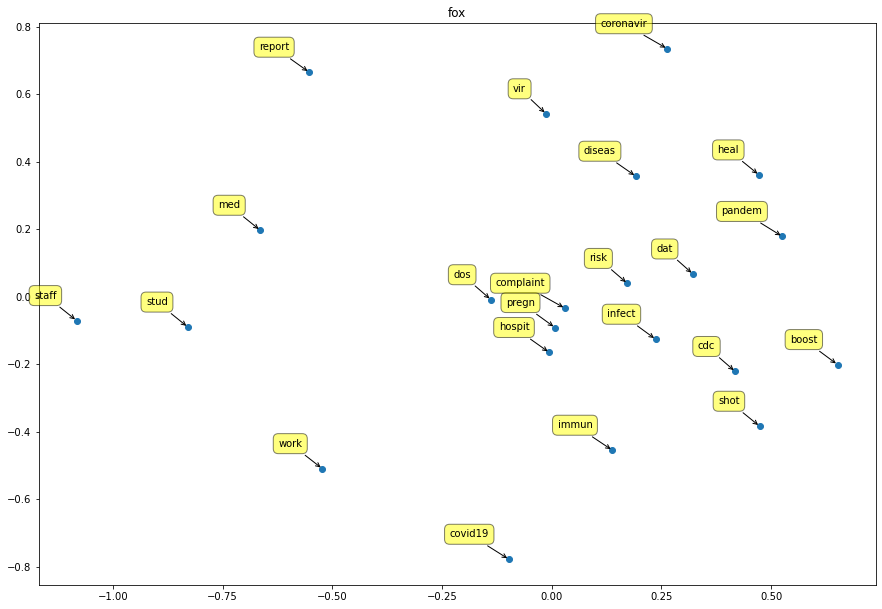

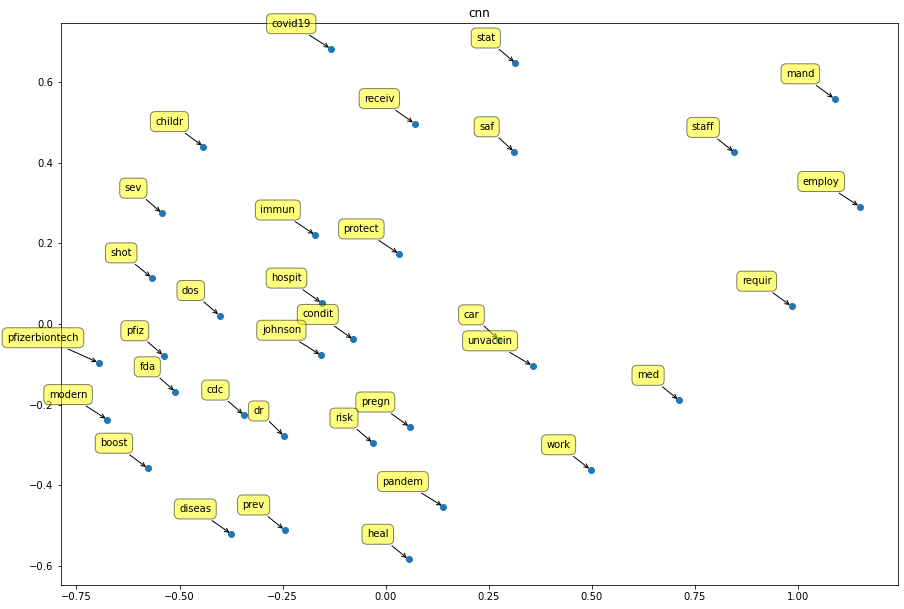

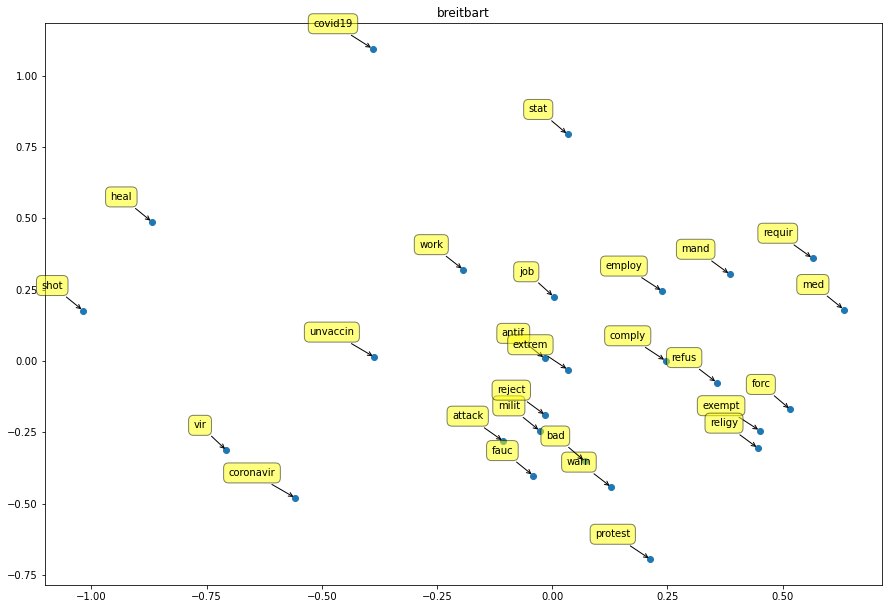

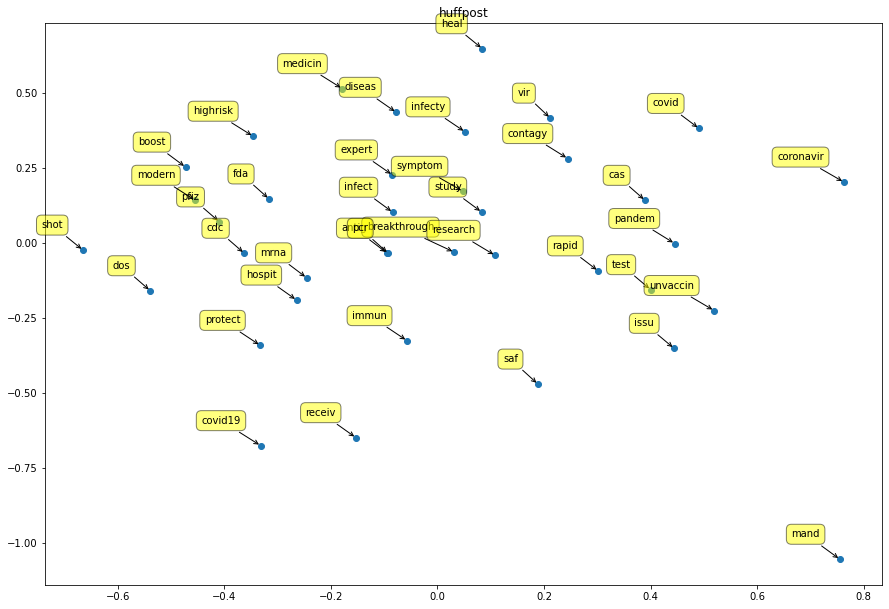

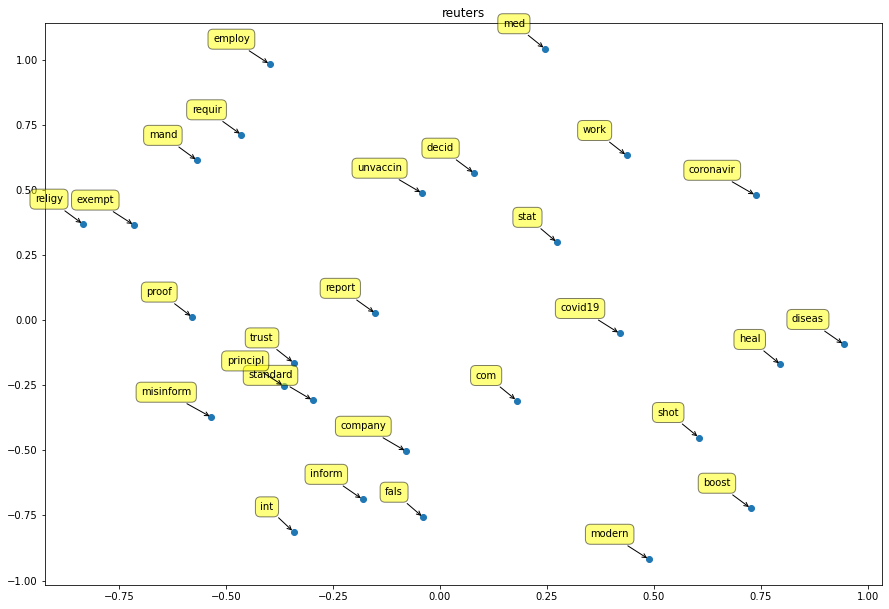

In [33]:
# Plot the MDS map using the computed dissimilarity matrix
print('We plot the MDS Maps as shown.')
for k,v in enumerate(dissim):
    mds = MDS(n_components=2, random_state=3, dissimilarity="precomputed")
    words_mds = mds.fit_transform(v)

    plt.figure(figsize=(15,10))
    plt.subplots_adjust(bottom = 0.1)
    plt.scatter(words_mds[:, 0], words_mds[:, 1], marker = 'o')

    for label, x, y in zip(all_words[k], words_mds[:, 0], words_mds[:, 1]):
        plt.annotate(
            label,
            xy = (x, y), xytext = (-20, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    plt.title(source_list[k])

    plt.show()

In [34]:
source_list

['fox', 'cnn', 'breitbart', 'huffpost', 'reuters']

In [35]:
df_fox_tweets = pd.read_csv('fox_tweet_locations.csv')[['content', 'Location']]
df_cnn_tweets = pd.read_csv('cnn_tweet_locations.csv')[['content', 'Location']]
df_breitbart_tweets = pd.read_csv('breit_tweet_locations.csv')[['content', 'Location']]
df_huffpost_tweets = pd.read_csv('huff_tweet_locations.csv')[['content', 'Location']]
df_reuters_tweets = pd.read_csv('reut_tweet_locations.csv')[['content', 'Location']]

In [36]:
#Fox
df_fox_tweets['cleaned_content'] = df_fox_tweets['content'].apply(escape_replacer)
df_fox_tweets['cleaned_content'] = df_fox_tweets['cleaned_content'].apply(lambda y:' '.join(filter(lambda x:x[0:5]!='https' and x[0]!='@', y.split())))
df_fox_tweets['cleaned_content'] = df_fox_tweets['cleaned_content'].apply(removepunc)
df_fox_tweets['source'] = 'fox'

#CNN
df_cnn_tweets['cleaned_content'] = df_cnn_tweets['content'].apply(escape_replacer)
df_cnn_tweets['cleaned_content'] = df_cnn_tweets['cleaned_content'].apply(lambda y:' '.join(filter(lambda x:x[0:5]!='https' and x[0]!='@', y.split())))
df_cnn_tweets['cleaned_content'] = df_cnn_tweets['cleaned_content'].apply(removepunc)
df_cnn_tweets['source'] = 'cnn'

#Breitbart
df_breitbart_tweets['cleaned_content'] = df_breitbart_tweets['content'].apply(escape_replacer)
df_breitbart_tweets['cleaned_content'] = df_breitbart_tweets['cleaned_content'].apply(lambda y:' '.join(filter(lambda x:x[0:5]!='https' and x[0]!='@', y.split())))
df_breitbart_tweets['cleaned_content'] = df_breitbart_tweets['cleaned_content'].apply(removepunc)
df_breitbart_tweets['source'] = 'breitbart'

#Huffpost
df_huffpost_tweets['cleaned_content'] = df_huffpost_tweets['content'].apply(escape_replacer)
df_huffpost_tweets['cleaned_content'] = df_huffpost_tweets['cleaned_content'].apply(lambda y:' '.join(filter(lambda x:x[0:5]!='https' and x[0]!='@', y.split())))
df_huffpost_tweets['cleaned_content'] = df_huffpost_tweets['cleaned_content'].apply(removepunc)
df_huffpost_tweets['source'] = 'huffpost'

#Reuters
df_reuters_tweets['cleaned_content'] = df_reuters_tweets['content'].apply(escape_replacer)
df_reuters_tweets['cleaned_content'] = df_reuters_tweets['cleaned_content'].apply(lambda y:' '.join(filter(lambda x:x[0:5]!='https' and x[0]!='@', y.split())))
df_reuters_tweets['cleaned_content'] = df_reuters_tweets['cleaned_content'].apply(removepunc)
df_reuters_tweets['source'] = 'reuters'

In [37]:
# sentiment_score(df_fox_tweets['cleaned_content'][0])
df_tweets = df_fox_tweets.append([df_cnn_tweets, df_breitbart_tweets, df_huffpost_tweets, df_reuters_tweets])
df_tweets.iloc[14]

content            @Jim_Jordan Exactly, stop saying no vaccines a...
Location                                                         NaN
cleaned_content    Exactly stop saying no vaccines and no masks f...
source                                                           fox
Name: 14, dtype: object

In [322]:
df_fox_tweets.to_csv('foxtweets.csv')

In [38]:
negative_scores = []
neutral_scores = []
positive_scores = []
compound_scores = []
average_sentiments = []

for i in range(0, len(df_tweets)):
    negative_scores.append(sd.polarity_scores(df_tweets['cleaned_content'].iloc[i])['neg'])
    neutral_scores.append(sd.polarity_scores(df_tweets['cleaned_content'].iloc[i])['neu'])
    positive_scores.append(sd.polarity_scores(df_tweets['cleaned_content'].iloc[i])['pos'])
    compound_scores.append(sd.polarity_scores(df_tweets['cleaned_content'].iloc[i])['compound'])
    if compound_scores[i] > 0.5:
        average_sentiments.append('Positive')
    elif compound_scores[i] < -0.5:
        average_sentiments.append('Negative')
    else:
        average_sentiments.append('Neutral')

df_tweets['Negative_Score'] = negative_scores
df_tweets['Neutral_Score'] = neutral_scores
df_tweets['Positive_Score'] = positive_scores
df_tweets['Compound_Score'] = compound_scores
df_tweets['Average_Sentiment'] = average_sentiments

df_tweets

,content,Location,cleaned_content,source,Negative_Score,Neutral_Score,Positive_Score,Compound_Score,Average_Sentiment
0,ESPN anchor Sage Steele is off the air after h...,so cal,ESPN anchor Sage Steele is off the air after h...,fox,0.120,0.880,0.000,-0.7096,Negative
1,"50,000 deaths directly attributable to anti-va...",NaN,50000 deaths directly attributable to antivacc...,fox,0.133,0.867,0.000,-0.2500,Neutral
2,In response to a COVID-19 vaccine mandate for ...,"Lake County, IL",In response to a COVID19 vaccine mandate for C...,fox,0.000,0.967,0.033,0.0258,Neutral
3,Healthcare workers file suit in Caddo District...,"Shreveport, LA",Healthcare workers file suit in Caddo District...,fox,0.000,1.000,0.000,0.0000,Neutral
4,Fox News is responsible for the COVID-19 death...,United States,Fox News is responsible for the COVID19 deaths...,fox,0.145,0.785,0.069,-0.3612,Neutral
...,...,...,...,...,...,...,...,...,...
1990,@Jo518Mag @WB4TWG @lMrMoonLightl @Reuters Ever...,NaN,Everything you suggested has been refuted As h...,reuters,0.161,0.839,0.000,-0.7269,Negative
1991,@callanswag2 @1mecross @Reuters Neither polio ...,NaN,Neither polio with vaccines,reuters,0.000,1.000,0.000,0.0000,Neutral
1992,@808Dopamine @kpatricke36m3 @Tboneator64 @DAMA...,NaN,If I told you being vaccinated makes it less l...,reuters,0.000,0.911,0.089,0.5423,Positive
1993,@kamorant @Reuters Imagine if you didn't take ...,NaN,Imagine if you didnt take care of yourself and...,reuters,0.074,0.774,0.151,0.6454,Positive


In [217]:
df_tweets_sentiments = df_tweets.groupby('source').agg({'Positive_Score': 'mean', 'Neutral_Score': 'mean', 'Negative_Score': 'mean', 'Compound_Score': 'mean'})
df_tweets_sentiments_temp = df_tweets.groupby(['source', 'Average_Sentiment']).size().unstack()
df_tweets_sentiments = df_tweets_sentiments.merge(df_tweets_sentiments_temp, left_index = True, right_index = True).rename(columns={'Negative': 'Negative_Count', 'Neutral': 'Neutral_Count', 'Positive': 'Positive_Count'})
print('Sentiment Scores:')
df_tweets_sentiments[['Compound_Score']]

Sentiment Scores:


,Compound_Score
source,
breitbart,-0.152368
cnn,-0.036957
fox,-0.172816
huffpost,-0.073754
reuters,0.029069


In [208]:
df_us = pd.read_csv('us_cities_states_counties.csv')
df_us = df_us['City|State short|State full|County|City alias '].str.split('|', n = -1, expand = True).rename(columns = {0: 'City', 1: 'State Short', 2: 'State Full', 3: 'County', 4: 'City alias'})
df_us = df_us[['City', 'State Short', 'State Full', 'County']].drop_duplicates()
df_us

,City,State Short,State Full,County
0,Holtsville,NY,New York,SUFFOLK
2,Adjuntas,PR,Puerto Rico,ADJUNTAS
6,Aguada,PR,Puerto Rico,AGUADA
12,Aguadilla,PR,Puerto Rico,AGUADILLA
45,Maricao,PR,Puerto Rico,MARICAO
...,...,...,...,...
63206,Klawock,AK,Alaska,PRINCE OF WALES HYDER
63207,Metlakatla,AK,Alaska,PRINCE OF WALES HYDER
63208,Point Baker,AK,Alaska,PRINCE OF WALES HYDER
63209,Ward Cove,AK,Alaska,KETCHIKAN GATEWAY


In [218]:
def isloc(sen):
    words = sen.lower().split()
    for w in words:
        for i in range(0, len(df_us)):
            if (w == str(df_us['City'].iloc[i]).lower() or w == str(df_us['State Short'].iloc[i]).lower() or w == str(df_us['State Full'].iloc[i]).lower() or w == str(df_us['County'].iloc[i]).lower()):
                return df_us['State Full'].iloc[i], df_us['County'].iloc[i]
            else:
                continue
    return '', ''

df_tweets_loc = df_tweets[df_tweets['Location'] != 'nan']
df_tweets_loc

tweet_loc_list = df_tweets_loc['Location'].apply(str).apply(removepunc).tolist()
final_loc_list = []

for i in range(0, len(tweet_loc_list)):
    print(i)
    final_loc_list.append(isloc(tweet_loc_list[i]))

final_loc_list

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


[('', ''),
 ('West Virginia', 'LOGAN'),
 ('Louisiana', 'CADDO'),
 ('Pennsylvania', 'WESTMORELAND'),
 ('Maine', 'YORK'),
 ('Maine', 'YORK'),
 ('', ''),
 ('Pennsylvania', 'WESTMORELAND'),
 ('New York', 'WAYNE'),
 ('Kentucky', 'METCALFE'),
 ('Pennsylvania', 'WESTMORELAND'),
 ('Missouri', 'SAINT LOUIS'),
 ('', ''),
 ('Pennsylvania', 'WESTMORELAND'),
 ('Idaho', 'BOISE'),
 ('', ''),
 ('', ''),
 ('Pennsylvania', 'WASHINGTON'),
 ('Kentucky', 'CLINTON'),
 ('Kentucky', 'PERRY'),
 ('Massachusetts', 'HAMPSHIRE'),
 ('Arizona', 'MARICOPA'),
 ('New York', 'STEUBEN'),
 ('Rhode Island', 'WASHINGTON'),
 ('', ''),
 ('Illinois', 'MCHENRY'),
 ('Florida', 'BAY'),
 ('Maine', 'YORK'),
 ('New Jersey', 'MONMOUTH'),
 ('Nevada', 'CLARK'),
 ('Tennessee', 'ROBERTSON'),
 ('New York', 'DUTCHESS'),
 ('Vermont', 'ORLEANS'),
 ('', ''),
 ('Massachusetts', 'WORCESTER'),
 ('Ohio', 'LUCAS'),
 ('Pennsylvania', 'WESTMORELAND'),
 ('Pennsylvania', 'WESTMORELAND'),
 ('Pennsylvania', 'WESTMORELAND'),
 ('Rhode Island', 'WASHINGTON

In [233]:
pd.DataFrame(final_loc_list)[0]

0                    
1       West Virginia
2           Louisiana
3        Pennsylvania
4               Maine
            ...      
3030      Connecticut
3031     Pennsylvania
3032    West Virginia
3033         New York
3034         New York
Name: 0, Length: 3035, dtype: object

In [318]:
import warnings
warnings.filterwarnings("ignore")
df_tweets_loc = pd.read_csv('df_tweets_loc.csv')
df_tweets_loc['State'] = pd.DataFrame(final_loc_list)[0]
df_tweets_loc['County'] = pd.DataFrame(final_loc_list)[1]

df_tweets_loc = df_tweets_loc[df_tweets_loc['State'] != '']

df_tweets_loc['State'] = df_tweets_loc['State'].str.lower()

df_tweets_loc

# df_state_leaning = pd.read_csv('State_leaning.csv')[['state', 'Leaning']]
# df_tweets_merged = df_tweets_loc.merge(df_state_leaning, left_on = 'Cleaned Location', right_on = 'state')

,Unnamed: 0,content,Location,cleaned_content,source,Negative_Score,Neutral_Score,Positive_Score,Compound_Score,Average_Sentiment,State,County
1,2,In response to a COVID-19 vaccine mandate for ...,Lake County IL,In response to a COVID19 vaccine mandate for C...,fox,0.000,0.967,0.033,0.0258,Neutral,west virginia,LOGAN
2,3,Healthcare workers file suit in Caddo District...,Shreveport LA,Healthcare workers file suit in Caddo District...,fox,0.000,1.000,0.000,0.0000,Neutral,louisiana,CADDO
3,4,Fox News is responsible for the COVID-19 death...,United States,Fox News is responsible for the COVID19 deaths...,fox,0.145,0.785,0.069,-0.3612,Neutral,pennsylvania,WESTMORELAND
4,5,There's something particularly galling about F...,New York NY,Theres something particularly galling about Fo...,fox,0.061,0.939,0.000,-0.2500,Neutral,maine,YORK
5,6,Fox News aired claims that undermine COVID-19 ...,New York NY,Fox News aired claims that undermine COVID19 v...,fox,0.306,0.694,0.000,-0.8316,Negative,maine,YORK
...,...,...,...,...,...,...,...,...,...,...,...,...
3030,1979,@1stpottergeek @Reuters @Galestorm250 They won...,Connecticut USA,They wont need it because the vaccine prevents...,reuters,0.177,0.753,0.070,-0.4588,Neutral,connecticut,HARTFORD
3031,1981,@politeabox @Lauriemac916 @Reuters What do the...,United States,What do the scientific studies report on mRNA ...,reuters,0.000,1.000,0.000,0.0000,Neutral,pennsylvania,WESTMORELAND
3032,1982,"@1stpottergeek @Reuters @Galestorm250 Wow, and...",London,Wow and it seems you consider yourself Liberal...,reuters,0.140,0.737,0.123,-0.2500,Neutral,west virginia,KANAWHA
3033,1983,@Reggz14728065 @sue288 @kenny19385 @OldCriedPa...,Memphis TN,And my miniscule chance of an adverse reaction...,reuters,0.098,0.838,0.064,-0.4019,Neutral,new york,ONONDAGA


In [319]:
def p2f(x):
    return float(x.strip('%'))/100

df_state_vacc = pd.read_csv('state_vaccine_rates.csv', converters={'Fully vaccinated':p2f})[['Location', 'Fully vaccinated']]
df_state_vacc['Fully vaccinated'].describe()

def vacc_conservative(vacc):
# 0.449, 0.491, 0.552,0.62
    if vacc <= 0.491:
        return 'Conservative'
    elif vacc <= 0.6:
        return 'Neutral'
    else:
        return 'Liberal'
    
df_state_vacc['Leaning'] = df_state_vacc['Fully vaccinated'].apply(vacc_conservative)
df_state_vacc['Location'] = df_state_vacc['Location'].str.lower()

df_state_vacc

df_tweets_loc = df_tweets_loc.merge(df_state_vacc, left_on = 'State', right_on = 'Location')
df_tweets_loc
    

,Unnamed: 0,content,Location_x,cleaned_content,source,Negative_Score,Neutral_Score,Positive_Score,Compound_Score,Average_Sentiment,State,County,Location_y,Fully vaccinated,Leaning
0,2,In response to a COVID-19 vaccine mandate for ...,Lake County IL,In response to a COVID19 vaccine mandate for C...,fox,0.000,0.967,0.033,0.0258,Neutral,west virginia,LOGAN,west virginia,0.407,Conservative
1,119,So Fox News has a vaccine mandate to enter the...,Orlando FL,So Fox News has a vaccine mandate to enter the...,fox,0.149,0.738,0.112,-0.2617,Neutral,west virginia,LEWIS,west virginia,0.407,Conservative
2,180,Fox has undermined vaccines nearly every day i...,Tyler TX,Fox has undermined vaccines nearly every day i...,fox,0.185,0.815,0.000,-0.3612,Neutral,west virginia,TYLER,west virginia,0.407,Conservative
3,205,Watchdog Report Exposes Stunning Frequency Of ...,Ohio USA,Watchdog Report Exposes Stunning Frequency Of ...,fox,0.176,0.697,0.127,-0.5994,Negative,west virginia,OHIO,west virginia,0.407,Conservative
4,219,@harrisonjaime It’s really hard to fathom thes...,London England,It’s really hard to fathom these people given...,fox,0.196,0.804,0.000,-0.7264,Negative,west virginia,KANAWHA,west virginia,0.407,Conservative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2208,44,@imdivaprincess I think they figured out that ...,Ames IA,I think they figured out that they are killing...,breitbart,0.190,0.735,0.076,-0.7003,Negative,iowa,STORY,iowa,0.545,Neutral
2209,55,That Breitbart guy who thought that libs are a...,Iowa,That Breitbart guy who thought that libs are a...,breitbart,0.253,0.682,0.065,-0.7650,Negative,iowa,WARREN,iowa,0.545,Neutral
2210,1341,@kaj33 @donlemon @CNN I truly wish Lebron and ...,Cascadia,I truly wish Lebron and some of these other cu...,cnn,0.075,0.665,0.260,0.7506,Positive,oregon,LINN,oregon,0.616,Liberal
2211,84,The newsletter also mentions and links to an a...,CarltonMcMinnvilleNewberg OR,The newsletter also mentions and links to an a...,breitbart,0.125,0.875,0.000,-0.7430,Negative,oregon,WASCO,oregon,0.616,Liberal


In [320]:
df_twt_sentiments = df_tweets_loc.groupby(['source', 'Leaning']).agg({'Compound_Score': 'mean'}).reset_index()
print('Sentiment Scores:')
df_twt_sentiments = df_twt_sentiments.pivot(index='Leaning', columns='source')

df_twt_sentiments

Sentiment Scores:


Compound_Score                                        
source            breitbart       cnn       fox  huffpost   reuters
Leaning                                                            
Conservative      -0.218509  0.002944 -0.221087 -0.309133  0.043518
Liberal           -0.175265 -0.065885 -0.199839 -0.052089  0.052736
Neutral           -0.166570  0.012476 -0.170328 -0.066930  0.032393

In [206]:
df_tweets_merged

df_twt_sentiments = df_tweets_merged.groupby(['source', 'Leaning']).agg({'Compound_Score': 'mean'}).reset_index()
print('Sentiment Scores:')
df_twt_sentiments = df_twt_sentiments.pivot(index='Leaning', columns='source')

df_twt_sentiments


# df_fox_merged = df_tweets_merged[df_tweets_merged['source'] == 'fox']
# df_cnn_merged = df_tweets_merged[df_tweets_merged['source'] == 'cnn']
# df_breitbart_merged = df_tweets_merged[df_tweets_merged['source'] == 'breitbart']
# df_reuters_merged = df_tweets_merged[df_tweets_merged['source'] == 'reuters']
# df_huffpost_merged = df_tweets_merged[df_tweets_merged['source'] == 'huffpost']

# #fox
# df_fox_sentiments = df_fox_merged.groupby('source').agg({'Positive_Score': 'mean', 'Neutral_Score': 'mean', 'Negative_Score': 'mean', 'Compound_Score': 'mean'})
# df_fox_sentiments_temp = df_fox_merged.groupby(['source', 'Average_Sentiment']).size().unstack()
# df_fox_sentiments = df_fox_sentiments.merge(df_fox_sentiments_temp, left_index = True, right_index = True).rename(columns={'Negative': 'Negative_Count', 'Neutral': 'Neutral_Count', 'Positive': 'Positive_Count'})
# print('Sentiment Scores (Fox):')
# df_fox_sentiments

# #cnn
# df_cnn_sentiments = df_cnn_merged.groupby('source').agg({'Positive_Score': 'mean', 'Neutral_Score': 'mean', 'Negative_Score': 'mean', 'Compound_Score': 'mean'})
# df_cnn_sentiments_temp = df_cnn_merged.groupby(['source', 'Average_Sentiment']).size().unstack()
# df_cnn_sentiments = df_cnn_sentiments.merge(df_cnn_sentiments_temp, left_index = True, right_index = True).rename(columns={'Negative': 'Negative_Count', 'Neutral': 'Neutral_Count', 'Positive': 'Positive_Count'})
# print('Sentiment Scores (CNN):')
# df_cnn_sentiments

# #breitbart
# df_breitbart_sentiments = df_breitbart_merged.groupby('source').agg({'Positive_Score': 'mean', 'Neutral_Score': 'mean', 'Negative_Score': 'mean', 'Compound_Score': 'mean'})
# df_breitbart_sentiments_temp = df_breitbart_merged.groupby(['source', 'Average_Sentiment']).size().unstack()
# df_breitbart_sentiments = df_breitbart_sentiments.merge(df_breitbart_sentiments_temp, left_index = True, right_index = True).rename(columns={'Negative': 'Negative_Count', 'Neutral': 'Neutral_Count', 'Positive': 'Positive_Count'})
# print('Sentiment Scores (Breitbart):')
# df_breitbart_sentiments

# #reuters
# df_reuters_sentiments = df_reuters_merged.groupby('source').agg({'Positive_Score': 'mean', 'Neutral_Score': 'mean', 'Negative_Score': 'mean', 'Compound_Score': 'mean'})
# df_reuters_sentiments_temp = df_reuters_merged.groupby(['source', 'Average_Sentiment']).size().unstack()
# df_reuters_sentiments = df_reuters_sentiments.merge(df_reuters_sentiments_temp, left_index = True, right_index = True).rename(columns={'Negative': 'Negative_Count', 'Neutral': 'Neutral_Count', 'Positive': 'Positive_Count'})
# print('Sentiment Scores (Reuters):')
# df_reuters_sentiments

# #huffpost
# df_huffpost_sentiments = df_huffpost_merged.groupby('source').agg({'Positive_Score': 'mean', 'Neutral_Score': 'mean', 'Negative_Score': 'mean', 'Compound_Score': 'mean'})
# df_huffpost_sentiments_temp = df_huffpost_merged.groupby(['source', 'Average_Sentiment']).size().unstack()
# df_huffpost_sentiments = df_huffpost_sentiments.merge(df_huffpost_sentiments_temp, left_index = True, right_index = True).rename(columns={'Negative': 'Negative_Count', 'Neutral': 'Neutral_Count', 'Positive': 'Positive_Count'})
# print('Sentiment Scores (Huffpost):')
# df_huffpost_sentiments

Sentiment Scores:


Compound_Score                                        
source            breitbart       cnn       fox  huffpost   reuters
Leaning                                                            
Conservative      -0.178950  0.050012 -0.205320 -0.613950  0.034904
Liberal           -0.169496 -0.074220 -0.180809 -0.010957  0.065964
Neutral           -0.186763  0.002503 -0.191838 -0.114033  0.026839